In [1]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from neuro_data_analysis.neural_data_lib import load_neural_data, load_img_resp_pairs, load_latent_codes

In [3]:
BFEStats_merge, BFEStats = load_neural_data()

In [5]:
Expi = 12
imgfps, resp_vec, bsl_vec, gen_vec = load_img_resp_pairs(BFEStats, Expi, "Evol", thread=0, stimdrive="S:", output_fmt="vec")
imgfps, resp_vec, bsl_vec, gen_vec = load_img_resp_pairs(BFEStats, Expi, "Evol", thread=1, stimdrive="S:", output_fmt="vec")
# imgfps_arr, resp_arr, bsl_arr, gen_arr = load_img_resp_pairs(BFEStats, Expi, "Evol", thread=1, stimdrive="S:", output_fmt="arr")

In [11]:
# find the path 
stim_path = BFEStats[Expi - 1].meta.stimuli
stim_path = stim_path.replace("N:", "S:")
stim_path

'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26'

### Loading latent codes 


In [17]:
import glob
import os
from scipy.io import loadmat

# List .mat files in the directory
mat_files = glob.glob(os.path.join(stim_path, "*.mat"))
print("Found .mat files:")
for f in mat_files:
    print(f)

# Load first .mat file to inspect
if len(mat_files) > 0:
    mat_data = loadmat(mat_files[3])
    print("\nContents of first .mat file:")
    print(mat_data.keys())

Found .mat files:
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block000_thread000_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block000_thread001_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block001_thread000_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block001_thread001_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block002_thread000_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block002_thread001_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block003_thread000_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block003_thread001_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block004_thread000_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block004_thread001_code.mat
S:\Stimuli\2020-BigGAN\2020-07-31-Beto-01\2020-07-31-11-07-26\block005_thread000_c

In [33]:
latent_codes = mat_data["codes"]
latent_ids = mat_data["ids"]
latent_ids_list = [str(val.item()) for val in latent_ids[0]]

In [43]:
import re
import numpy as np
import pandas as pd

# load the latent codes for all generations. 
def load_latent_codes(stim_path, thread_id=1, verbose=False):
    """Load latent codes and metadata from .mat files for a specific thread.
    
    Args:
        stim_path (str): Path to directory containing .mat files
        thread_id (int): Thread ID to load files for, 0, 1 or None
        verbose (bool): Whether to print progress information
        
    Returns:
        tuple: (latent_codes_all, image_ids_list_all, gen_vec_all, thread_i_vec_all)
    """
    if thread_id is None:
        mat_files = sorted(glob.glob(os.path.join(stim_path, f"*thread*_code.mat")))
    else:
        mat_files = sorted(glob.glob(os.path.join(stim_path, f"*thread{thread_id:03d}_code.mat")))
    if verbose:
        print(f"Found {len(mat_files)} .mat files:")
    
    latent_codes_all = []
    image_ids_list_all = []
    gen_vec_all = []
    thread_i_vec_all = []
    
    for f in mat_files:
        mat_data = loadmat(f)
        # parse the file name to get the generation number, using regex
        block_num = int(re.search(r'block(\d+)_', f).group(1))
        thread_num = int(re.search(r'_thread(\d+)_', f).group(1))
        latent_codes = mat_data["codes"]
        latent_ids = mat_data["ids"]
        latent_ids_list = [str(val.item()) for val in latent_ids[0]]
        latent_codes_all.append(latent_codes)
        image_ids_list_all.extend(latent_ids_list)
        gen_vec_all.extend([block_num for _ in range(len(latent_ids_list))])
        thread_i_vec_all.extend([thread_num for _ in range(len(latent_ids_list))])

    latent_codes_all = np.concatenate(latent_codes_all, axis=0)
    gen_vec_all = np.array(gen_vec_all)
    thread_i_vec_all = np.array(thread_i_vec_all)
    
    if verbose:
        print("max block num: ", max(gen_vec_all))
        print("latent_codes_all.shape: ", latent_codes_all.shape) 
        print("num of images: ", len(image_ids_list_all))
        
    return latent_codes_all, image_ids_list_all, gen_vec_all, thread_i_vec_all


In [52]:
latent_codes_all_thr1, latent_image_ids_thr1, latent_gen_vec_thr1, _ = load_latent_codes(stim_path, thread_id=1, verbose=True)
latent_codes_all_thr0, latent_image_ids_thr0, latent_gen_vec_thr0, _ = load_latent_codes(stim_path, thread_id=0, verbose=True)

Found 35 .mat files:
max block num:  34
latent_codes_all.shape:  (880, 128)
num of images:  880
Found 35 .mat files:
max block num:  34
latent_codes_all.shape:  (1390, 4096)
num of images:  1390


In [64]:
latent_image_ids_thr1[29]

'founder_030'

In [54]:
imgfps_thr0, resp_vec_thr0, bsl_vec_thr0, gen_vec_thr0 = load_img_resp_pairs(BFEStats, Expi, "Evol", thread=0, stimdrive="S:", output_fmt="vec")
imgfps_thr1, resp_vec_thr1, bsl_vec_thr1, gen_vec_thr1 = load_img_resp_pairs(BFEStats, Expi, "Evol", thread=1, stimdrive="S:", output_fmt="vec")

In [56]:
# align the latent codes to the image fps
imgids_thr0 = [imgfps_thr0[i].split("\\")[-1] for i in range(len(imgfps_thr0))]
imgids_thr1 = [imgfps_thr1[i].split("\\")[-1] for i in range(len(imgfps_thr1))]

In [60]:
# Check for ids that are in one list but not the other
ids_only_in_latent = set(latent_image_ids_thr1) - set(imgids_thr1)
ids_only_in_imgs = set(imgids_thr1) - set(latent_image_ids_thr1)


print("IDs only in latent_image_ids_thr1:", len(ids_only_in_latent))
if len(ids_only_in_latent) > 0:
    # print("Examples:", sorted(list(ids_only_in_latent))[:10])
    print("Examples:", list(ids_only_in_latent))

print("\nIDs only in imgids_thr1:", len(ids_only_in_imgs))
if len(ids_only_in_imgs) > 0:
    # print("Examples:", sorted(list(ids_only_in_imgs))[:10])
    print("Examples:", list(ids_only_in_imgs))



IDs only in latent_image_ids_thr1: 55
Examples: ['founder_005', 'founder_010', 'block035_thread001_gen_gen034_002264.bmp', 'block035_thread001_gen_gen034_002261.bmp', 'founder_009', 'founder_001', 'block035_thread001_gen_gen034_002251.bmp', 'block035_thread001_gen_gen034_002267.bmp', 'founder_026', 'block035_thread001_gen_gen034_002254.bmp', 'founder_024', 'block035_thread001_gen_gen034_002263.bmp', 'founder_004', 'block035_thread001_gen_gen034_002256.bmp', 'block035_thread001_gen_gen034_002255.bmp', 'block035_thread001_gen_gen034_002265.bmp', 'founder_007', 'founder_025', 'block035_thread001_gen_gen034_002262.bmp', 'founder_021', 'block035_thread001_gen_gen034_002266.bmp', 'founder_028', 'founder_014', 'founder_022', 'block035_thread001_gen_gen034_002245.bmp', 'founder_002', 'block035_thread001_gen_gen034_002260.bmp', 'block035_thread001_gen_gen034_002247.bmp', 'block035_thread001_gen_gen034_002268.bmp', 'founder_020', 'founder_030', 'block035_thread001_gen_gen034_002257.bmp', 'founde

In [76]:
import pandas as pd
# make a data frame and try to merge the two data frames
df_latent = pd.DataFrame()
df_latent["image_id"] = latent_image_ids_thr1
df_latent["gen_vec"] = latent_gen_vec_thr1
df_latent["latent_code"] = list(latent_codes_all_thr1)
print(df_latent.head())

df_img_resp = pd.DataFrame()
df_img_resp["image_fps"] = imgfps_thr1
df_img_resp["image_id"] = imgids_thr1
df_img_resp["resp"] = list(resp_vec_thr1)
df_img_resp["bsl"] = list(bsl_vec_thr1)
df_img_resp["gen_vec"] = gen_vec_thr1
df_img_resp_latent = pd.merge(df_img_resp, df_latent, on="image_id", how="inner")

      image_id  gen_vec                                        latent_code
0  founder_001        0  [0.06747385295829367, 0.008675944500847502, -0...
1  founder_002        0  [-0.03982506296309421, -0.016778787675946157, ...
2  founder_003        0  [-0.05267764078492032, -0.06713585568073872, 0...
3  founder_004        0  [-0.005524349060505158, 0.10987621192295345, -...
4  founder_005        0  [-0.021634113692263205, 0.04850944342691209, -...


In [77]:
# Build linear model to predict response from latent code
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split

# Extract features (X) and target (y)
X = np.array(df_img_resp_latent['latent_code'].tolist())
y = df_img_resp_latent['resp'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = RidgeCV(alphas=[0.01, 0.1, 1, 10])
model.fit(X_train, y_train)

# Get model performance metrics
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Linear model R² score on train set: {train_score:.3f}")
print(f"Linear model R² score on test set: {test_score:.3f}")

Linear model R² score on train set: 0.169
Linear model R² score on test set: 0.096


### function to train linear model


In [9]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split

def train_linear_model(df_img_resp_latent, test_size=0.2, random_state=42, alphas=[0.01, 0.1, 1, 10], projection_matrix=None, X_key="latent_code", y_key="resp"):
    """
    Train a Ridge regression model to predict responses from latent codes.
    



    Args:
        df_img_resp_latent: DataFrame containing latent codes and responses
        test_size: Fraction of data to use for testing (default 0.2)
        random_state: Random seed for train/test split (default 42)
        alphas: List of alpha values to try for Ridge regression (default [0.01, 0.1, 1, 10])
    
    Returns:
        model: Trained RidgeCV model
        train_score: R² score on training set
        test_score: R² score on test set
    """
    # Extract features (X) and target (y)
    X = np.array(df_img_resp_latent[X_key].tolist())
    if projection_matrix is not None:
        X = X @ projection_matrix
    y = df_img_resp_latent[y_key].values
    bsl = df_img_resp_latent['bsl'].values
    print(f"X.shape: {X.shape}, y.shape: {y.shape}")

    print(f"resp mean and std, min, max: {np.mean(y):.3f}, {np.std(y):.3f}, {np.min(y):.3f}, {np.max(y):.3f}")
    print(f"baseline mean and std, min, max: {np.mean(bsl):.3f}, {np.std(bsl):.3f}, {np.min(bsl):.3f}, {np.max(bsl):.3f}")
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Fit linear regression model
    model = RidgeCV(alphas=alphas)
    model.fit(X_train, y_train)
    # print final alpha
    print(f"Final alpha: {model.alpha_}")
    # Get model performance metrics
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Linear model R² score on train set: {train_score:.3f}")
    print(f"Linear model R² score on test set: {test_score:.3f}")
    
    return model, train_score, test_score

In [10]:
def load_and_merge_data(BFEStats, Expi, thread_id=1, stimdrive="S:", verbose=True):
    """
    Load latent codes and image response data and merge them into a single dataframe.
    
    Args:
        stim_path: Path to stimulus files
        BFEStats: BFE statistics object
        Expi: Experiment ID
        thread_id: Thread ID to load data from (default 1)
        stimdrive: Drive letter for stimulus files (default "S:")
        verbose: Whether to print debug info (default True)
        
    Returns:
        df_img_resp_latent: Merged dataframe containing image responses and latent codes
    """
    stim_path = BFEStats[Expi - 1].meta.stimuli
    stim_path = stim_path.replace("N:", "S:")
    # Load latent codes
    latent_codes_all, latent_image_ids, latent_gen_vec, _ = load_latent_codes(
        stim_path, thread_id=thread_id, verbose=verbose
    )
    # Load image response pairs
    imgfps, resp_vec, bsl_vec, gen_vec = load_img_resp_pairs(
        BFEStats, Expi, "Evol", thread=thread_id, stimdrive=stimdrive, output_fmt="vec"
    )
    # Create latent code dataframe
    df_latent = pd.DataFrame()
    df_latent["image_id"] = latent_image_ids
    df_latent["gen_vec"] = latent_gen_vec
    df_latent["latent_code"] = list(latent_codes_all)
    #TODO: potentially rename the founders to the true image ids to get more accurate results
    # if verbose:
        # print(df_latent.head())
    # Create image response dataframe

    df_img_resp = pd.DataFrame()
    df_img_resp["image_fps"] = imgfps
    df_img_resp["image_id"] = [name.split("\\")[-1] for name in imgfps]
    df_img_resp["resp"] = list(resp_vec)
    df_img_resp["bsl"] = list(bsl_vec)
    df_img_resp["gen_vec"] = gen_vec

    # Merge dataframes
    df_img_resp_latent = pd.merge(df_img_resp, df_latent, on="image_id", how="inner")
    return df_img_resp_latent

In [96]:
df_img_resp_latent = load_and_merge_data(BFEStats, Expi, thread_id=0, stimdrive="S:", verbose=True)
model, train_score, test_score = train_linear_model(df_img_resp_latent, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 50))

Found 35 .mat files:
max block num:  34
latent_codes_all.shape:  (1390, 4096)
num of images:  1390
      image_id  gen_vec                                        latent_code
0  founder_001        0  [-0.32454691555976517, -0.507499399584177, 0.3...
1  founder_002        0  [4.711568893568321, -0.9007545919080426, -0.19...
2  founder_003        0  [1.1218659195424452, 1.6846226542683003, -3.09...
3  founder_004        0  [0.18399954633692947, -0.1281708412242693, -4....
4  founder_005        0  [0.9470839092699269, -0.728258523219413, 3.451...
X.shape: (1321, 4096), y.shape: (1321,)
resp mean and std, min, max: 180.943, 52.009, 33.299, 366.218
baseline mean and std, min, max: 27.137, 39.361, 0.000, 295.848
Final alpha: 754312.0063354607
Linear model R² score on train set: 0.368
Linear model R² score on test set: 0.283


In [97]:
df_img_resp_latent = load_and_merge_data(BFEStats, Expi, thread_id=1, stimdrive="S:", verbose=True)
model, train_score, test_score = train_linear_model(df_img_resp_latent, test_size=0.2, random_state=42, alphas=np.logspace(-3, 3, 50))

Found 35 .mat files:
max block num:  34
latent_codes_all.shape:  (880, 128)
num of images:  880
      image_id  gen_vec                                        latent_code
0  founder_001        0  [0.06747385295829367, 0.008675944500847502, -0...
1  founder_002        0  [-0.03982506296309421, -0.016778787675946157, ...
2  founder_003        0  [-0.05267764078492032, -0.06713585568073872, 0...
3  founder_004        0  [-0.005524349060505158, 0.10987621192295345, -...
4  founder_005        0  [-0.021634113692263205, 0.04850944342691209, -...
X.shape: (825, 128), y.shape: (825,)
resp mean and std, min, max: 225.932, 46.873, 33.299, 368.048
baseline mean and std, min, max: 27.097, 37.372, 0.000, 231.073
Final alpha: 8.286427728546842
Linear model R² score on train set: 0.177
Linear model R² score on test set: 0.098


### Case study, Expi 65

In [9]:
import seaborn as sns

In [174]:
Expi = 65
df_img_resp_latent_thr0 = load_and_merge_data(BFEStats, Expi, thread_id=0, stimdrive="S:", verbose=True)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 50))
df_img_resp_latent_thr1 = load_and_merge_data(BFEStats, Expi, thread_id=1, stimdrive="S:", verbose=True)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 3, 50))

Found 42 .mat files:
max block num:  41
latent_codes_all.shape:  (1260, 4096)
num of images:  1260
X.shape: (1236, 4096), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 91029.81779915227
Linear model R² score on train set: 0.422
Linear model R² score on test set: 0.377
Found 42 .mat files:
max block num:  41
latent_codes_all.shape:  (1178, 256)
num of images:  1178
X.shape: (1157, 256), y.shape: (1157,)
resp mean and std, min, max: 249.344, 47.368, 85.227, 408.085
baseline mean and std, min, max: 108.729, 59.094, 0.000, 376.498
Final alpha: 25.595479226995334
Linear model R² score on train set: 0.235
Linear model R² score on test set: 0.182


<Axes: xlabel='gen_vec_x', ylabel='resp'>

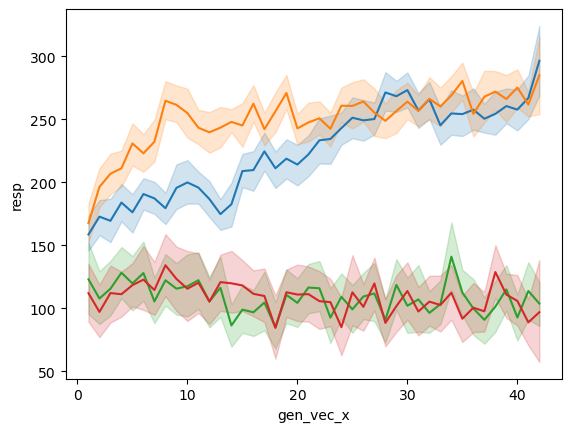

In [ ]:
sns.lineplot(data=df_img_resp_latent_thr0, x="gen_vec_x", y="resp", )
sns.lineplot(data=df_img_resp_latent_thr1, x="gen_vec_x", y="resp", )
sns.lineplot(data=df_img_resp_latent_thr0, x="gen_vec_x", y="bsl", )
sns.lineplot(data=df_img_resp_latent_thr1, x="gen_vec_x", y="bsl", )

#### Translate the BigGAN images to the DeePSim latent space via CaffeNet

In [10]:
# load caffenet from 
from core.utils.GAN_utils import Caffenet
caffenet = Caffenet(pretrained=True)
caffenet.eval().cuda()

c:\Users\ponce\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Caffenet(
  (net): Sequential(
    (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (relu2): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu4): ReLU(inplace=True)
    (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu5): ReLU(inplace=True)
    (pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)

In [181]:
caffenet.net[:-3]

Sequential(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu5): ReLU(inplace=True)
  (pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  

In [4]:
# Load and preprocess images
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import torch
import tqdm

def process_images_batch_add_activations(df, caffenet, batch_size=128, layer_idx=-3):
    """Process images in batches through CaffeNet and extract fc6 activations
    
    Args:
        df: DataFrame containing image file paths in 'image_fps' column
        caffenet: CaffeNet model instance
        batch_size: Size of batches for processing (default 64)
        
    Returns:
        DataFrame with added 'caffenet_fc6_act' column containing activations
    """
    # Get list of image paths
    image_fps = df['image_fps'].tolist()
    activations = []

    # Process images in batches
    for i in tqdm.trange(0, len(image_fps), batch_size):
        batch_fps = image_fps[i:i+batch_size]
        batch_tensors = []
        # Prepare batch
        for fp in batch_fps:
            img = Image.open(fp)
            img = img.resize((224, 224), Image.BILINEAR)
            img_tensor = ToTensor()(img)
            batch_tensors.append(img_tensor)
        
        # Stack tensors into batch
        batch = torch.stack(batch_tensors).cuda()
        
        # Process batch
        with torch.no_grad():
            # Forward pass through caffenet up to relu6
            batch_acts = caffenet.net[:layer_idx](batch)
            # Store flattened activation vectors
            activations.extend(batch_acts.cpu().numpy().reshape(len(batch_fps), -1))

    # Add activations as new column
    df['caffenet_fc6_act'] = activations
    return df

# Process the dataframe
df_img_resp_latent_thr1 = process_images_batch_add_activations(df_img_resp_latent_thr1, caffenet)
df_img_resp_latent_thr1

NameError: name 'df_img_resp_latent_thr1' is not defined

In [17]:
if False:
    import torch
    from torch.utils.data import Dataset, DataLoader
    from torchvision import transforms
    from PIL import Image
    import tqdm


    # 1) Create a custom Dataset that loads images from file paths
    class ImageDataset(Dataset):
        def __init__(self, df, transform=None):
            """
            Args:
                df: DataFrame with 'image_fps' column containing paths to images.
                transform: Transformations (transforms.Compose) to apply to the images.
            """
            self.image_fps = df['image_fps'].tolist()
            self.transform = transform

        def __len__(self):
            return len(self.image_fps)

        def __getitem__(self, idx):
            img_fp = self.image_fps[idx]
            # Load image
            img = Image.open(img_fp).convert('RGB')  # convert to RGB just in case
            if self.transform:
                img = self.transform(img)
            return img

    def process_images_batch_add_activations(
        df, 
        caffenet, 
        batch_size=128, 
        layer_idx=-3, 
        num_workers=8
    ):
        """
        Process images in batches through CaffeNet and extract fc6 activations

        Args:
            df: DataFrame containing image file paths in 'image_fps' column
            caffenet: CaffeNet model instance
            batch_size: Size of batches for processing (default 128)
            layer_idx: Up to which layer in the model to forward pass (default -3)
            num_workers: Number of workers for the DataLoader (default 4)

        Returns:
            DataFrame with new 'caffenet_fc6_act' column containing activations
        """
        # 2) Define transformations - resize + tensor
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        # Create dataset and dataloader
        dataset = ImageDataset(df, transform=transform)
        dataloader = DataLoader(
            dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=num_workers, 
            pin_memory=False  # helps speed up GPU transfers
        )

        all_activations = []

        # 3) Iterate over DataLoader
        for batch in tqdm.tqdm(dataloader, desc="Processing batches"):
            batch = batch.cuda()
            with torch.no_grad():
                batch_acts = caffenet.net[:layer_idx](batch)
            # Flatten and store
            all_activations.extend(batch_acts.cpu().numpy().reshape(batch_acts.size(0), -1))
        
        # Add activations to the DataFrame
        df['caffenet_fc6_act'] = all_activations
        
        return df

    # Then run:
    df_img_resp_latent_thr1 = process_images_batch_add_activations(df_img_resp_latent_thr1, caffenet)
    df_img_resp_latent_thr1

Processing batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [204]:
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="latent_code", y_key="resp")

X.shape: (1236, 4096), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 107226.72220103253
Linear model R² score on train set: 0.418
Linear model R² score on test set: 0.377


In [205]:
df_img_resp_latent_thr0 = process_images_batch_add_activations(df_img_resp_latent_thr0, caffenet)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act", y_key="resp")

100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


X.shape: (1236, 4096), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 572.236765935022
Linear model R² score on train set: 0.436
Linear model R² score on test set: 0.342


In [206]:
model_caffenet_fc6, train_score_caffenet_fc6, test_score_caffenet_fc6 = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="latent_code", y_key="resp")

X.shape: (1157, 256), y.shape: (1157,)
resp mean and std, min, max: 249.344, 47.368, 85.227, 408.085
baseline mean and std, min, max: 108.729, 59.094, 0.000, 376.498
Final alpha: 24.77076355991714
Linear model R² score on train set: 0.236
Linear model R² score on test set: 0.183


In [207]:
model_caffenet_fc6, train_score_caffenet_fc6, test_score_caffenet_fc6 = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act", y_key="resp")

X.shape: (1157, 4096), y.shape: (1157,)
resp mean and std, min, max: 249.344, 47.368, 85.227, 408.085
baseline mean and std, min, max: 108.729, 59.094, 0.000, 376.498
Final alpha: 200.92330025650458
Linear model R² score on train set: 0.313
Linear model R² score on test set: 0.216


In [191]:
# load the hession from local and use it as a projection matrix
H_data = np.load(Hdir_fc6, allow_pickle=True)
eigvals = H_data['eigv_avg']
eigvects = H_data['eigvect_avg']
assert eigvals[-1] > eigvals[-2]
# projection_matrix = eigvects @ np.diag(eigvals)
projection_matrix = eigvects[:, -256:]
model_caffenet_fc6, train_score_caffenet_fc6, test_score_caffenet_fc6 = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 9, 100), 
                                                                                           X_key="caffenet_fc6_act", y_key="resp", projection_matrix=projection_matrix)

X.shape: (1157, 256), y.shape: (1157,)
resp mean and std, min, max: 249.344, 47.368, 85.227, 408.085
baseline mean and std, min, max: 108.729, 59.094, 0.000, 376.498
Final alpha: 40.37017258596558
Linear model R² score on train set: 0.298
Linear model R² score on test set: 0.223


In [198]:
np.random.seed(45)
projection_matrix = np.random.randn(4096, 256)
# orthogonalize the projection matrix
projection_matrix = np.linalg.qr(projection_matrix)[0]
model_caffenet_fc6, train_score_caffenet_fc6, test_score_caffenet_fc6 = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 9, 100), 
                                                                                           X_key="caffenet_fc6_act", y_key="resp", projection_matrix=projection_matrix)

X.shape: (1157, 256), y.shape: (1157,)
resp mean and std, min, max: 249.344, 47.368, 85.227, 408.085
baseline mean and std, min, max: 108.729, 59.094, 0.000, 376.498
Final alpha: 13.219411484660288
Linear model R² score on train set: 0.302
Linear model R² score on test set: 0.219


#### Projecting the DeePSim latent codes to match the BigGAN latent codes dimensionally







In [157]:
import sys 
if sys.platform == "linux":
    # rootdir = r"/scratch/binxu/BigGAN_Optim_Tune_new"
    # Hdir_BigGAN = r"/scratch/binxu/GAN_hessian/BigGAN/summary/H_avg_1000cls.npz"
    # Hdir_fc6 = r"/scratch/binxu/GAN_hessian/FC6GAN/summary/Evolution_Avg_Hess.npz"
    # O2 path interface
    scratchdir = "/n/scratch3/users/b/biw905"  # os.environ['SCRATCH1']
    # rootdir = join(scratchdir, "GAN_Evol_cmp")
    rootdir = join(scratchdir, "GAN_Evol_Dissection")
    Hdir_BigGAN = join("/home/biw905/Hessian", "H_avg_1000cls.npz")  #r"/scratch/binxu/GAN_hessian/BigGAN/summary/H_avg_1000cls.npz"
    Hdir_fc6 = join("/home/biw905/Hessian", "Evolution_Avg_Hess.npz")  #r"/scratch/binxu/GAN_hessian/FC6GAN/summary/Evolution_Avg_Hess.npz"
else:
    rootdir = r"F:\insilico_exps\GAN_Evol_Dissection"
    Hdir_BigGAN = r"E:\OneDrive - Washington University in St. Louis\Hessian_summary\BigGAN\H_avg_1000cls.npz"
    Hdir_fc6 = r"E:\OneDrive - Washington University in St. Louis\Hessian_summary\fc6GAN\Evolution_Avg_Hess.npz"

In [212]:
model_proj, train_score_proj, test_score_proj = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=None)

X.shape: (1236, 4096), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 107226.72220103253
Linear model R² score on train set: 0.418
Linear model R² score on test set: 0.377


In [208]:
# load the hession from local and use it as a projection matrix
H_data = np.load(Hdir_fc6, allow_pickle=True)
eigvals = H_data['eigv_avg']
eigvects = H_data['eigvect_avg']
assert eigvals[-1] > eigvals[-2]
# projection_matrix = eigvects @ np.diag(eigvals)
projection_matrix = eigvects[:, -256:]
model_proj, train_score_proj, test_score_proj = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=projection_matrix)

X.shape: (1236, 256), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 53366.99231206313
Linear model R² score on train set: 0.414
Linear model R² score on test set: 0.374


In [209]:
# load the hession from local and use it as a projection matrix
H_data = np.load(Hdir_fc6, allow_pickle=True)
eigvals = H_data['eigv_avg']
eigvects = H_data['eigvect_avg']
assert eigvals[-1] > eigvals[-2]
# projection_matrix = eigvects[:, 2000:2256] # this is the null space of the hessian
projection_matrix = eigvects[:, -128:] # this is the top eigenspace of the hessian
model_proj, train_score_proj, test_score_proj = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=projection_matrix)


X.shape: (1236, 128), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 26560.877829466895
Linear model R² score on train set: 0.414
Linear model R² score on test set: 0.364


In [211]:
# generate a random projection from 4096 to 256 dimensions
# keep the random seed fixed
np.random.seed(41)
projection_matrix = np.random.randn(4096, 256)
# orthogonalize the projection matrix
projection_matrix = np.linalg.qr(projection_matrix)[0]
model_proj, train_score_proj, test_score_proj = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 50), projection_matrix=projection_matrix)

X.shape: (1236, 256), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 5428.67543932386
Linear model R² score on train set: 0.414
Linear model R² score on test set: 0.374


In [61]:
# Check for ids that are in one list but not the other
ids_only_in_latent = set(latent_image_ids_thr0) - set(imgids_thr0)
ids_only_in_imgs = set(imgids_thr0) - set(latent_image_ids_thr0)


print("IDs only in latent_image_ids_thr0:", len(ids_only_in_latent))
if len(ids_only_in_latent) > 0:
    # print("Examples:", sorted(list(ids_only_in_latent))[:10])
    print("Examples:", list(ids_only_in_latent))


print("\nIDs only in imgids_thr0:", len(ids_only_in_imgs))
if len(ids_only_in_imgs) > 0:
    # print("Examples:", sorted(list(ids_only_in_imgs))[:10])
    print("Examples:", list(ids_only_in_imgs))



IDs only in latent_image_ids_thr0: 69
Examples: ['founder_005', 'block035_thread000_gen_gen034_002234.bmp', 'founder_010', 'founder_009', 'block035_thread000_gen_gen034_002227.bmp', 'founder_001', 'founder_026', 'founder_024', 'block035_thread000_gen_gen034_002239.bmp', 'founder_004', 'block035_thread000_gen_gen034_002206.bmp', 'block035_thread000_gen_gen034_002224.bmp', 'block035_thread000_gen_gen034_002211.bmp', 'block035_thread000_gen_gen034_002241.bmp', 'block035_thread000_gen_gen034_002222.bmp', 'block035_thread000_gen_gen034_002243.bmp', 'block035_thread000_gen_gen034_002226.bmp', 'founder_007', 'founder_025', 'founder_021', 'block035_thread000_gen_gen034_002231.bmp', 'block035_thread000_gen_gen034_002238.bmp', 'block035_thread000_gen_gen034_002228.bmp', 'founder_028', 'founder_014', 'founder_022', 'block035_thread000_gen_gen034_002215.bmp', 'block035_thread000_gen_gen034_002237.bmp', 'block035_thread000_gen_gen034_002208.bmp', 'block035_thread000_gen_gen034_002219.bmp', 'block03

### Massive compute

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
if sys.platform == "linux":
    # rootdir = r"/scratch/binxu/BigGAN_Optim_Tune_new"
    # Hdir_BigGAN = r"/scratch/binxu/GAN_hessian/BigGAN/summary/H_avg_1000cls.npz"
    # Hdir_fc6 = r"/scratch/binxu/GAN_hessian/FC6GAN/summary/Evolution_Avg_Hess.npz"
    # O2 path interface
    scratchdir = "/n/scratch3/users/b/biw905"  # os.environ['SCRATCH1']
    # rootdir = join(scratchdir, "GAN_Evol_cmp")
    rootdir = join(scratchdir, "GAN_Evol_Dissection")
    Hdir_BigGAN = join("/home/biw905/Hessian", "H_avg_1000cls.npz")  #r"/scratch/binxu/GAN_hessian/BigGAN/summary/H_avg_1000cls.npz"
    Hdir_fc6 = join("/home/biw905/Hessian", "Evolution_Avg_Hess.npz")  #r"/scratch/binxu/GAN_hessian/FC6GAN/summary/Evolution_Avg_Hess.npz"
else:
    rootdir = r"F:\insilico_exps\GAN_Evol_Dissection"
    Hdir_BigGAN = r"E:\OneDrive - Washington University in St. Louis\Hessian_summary\BigGAN\H_avg_1000cls.npz"
    Hdir_fc6 = r"E:\OneDrive - Washington University in St. Louis\Hessian_summary\fc6GAN\Evolution_Avg_Hess.npz"

H_data = np.load(Hdir_fc6, allow_pickle=True)
eigvals = H_data['eigv_avg']
eigvects = H_data['eigvect_avg']
assert eigvals[-1] > eigvals[-2]
# projection_matrix = eigvects[:, 2000:2256] # this is the null space of the hessian

In [7]:
# load caffenet from 
from core.utils.GAN_utils import Caffenet
caffenet = Caffenet(pretrained=True)
caffenet.eval().cuda();

c:\Users\ponce\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
np.random.seed(42)
proj_mat = np.random.randn(4096, 256)
proj_mat_rnd256 = np.linalg.qr(proj_mat)[0]
np.random.seed(41)
proj_mat = np.random.randn(4096, 128)
proj_mat_rnd128 = np.linalg.qr(proj_mat)[0]

proj_mat_hess_top128 = eigvects[:, -128:] # this is the top eigenspace of the hessian
proj_mat_hess_top256 = eigvects[:, -256:] # this is the top eigenspace of the hessian
proj_mat_hess_null128 = eigvects[:, :128] # this is the top eigenspace of the hessian
proj_mat_hess_null256 = eigvects[:, :256] # this is the top eigenspace of the hessian


Expi = 65
df_img_resp_latent_thr0 = load_and_merge_data(BFEStats, Expi, thread_id=0, stimdrive="S:", verbose=True)
df_img_resp_latent_thr1 = load_and_merge_data(BFEStats, Expi, thread_id=1, stimdrive="S:", verbose=True)

df_img_resp_latent_thr0 = process_images_batch_add_activations(df_img_resp_latent_thr0, caffenet, batch_size=128, )
df_img_resp_latent_thr1 = process_images_batch_add_activations(df_img_resp_latent_thr1, caffenet, batch_size=128, )

model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100))
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=proj_mat_hess_top128)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=proj_mat_hess_top256)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=proj_mat_hess_null128)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=proj_mat_hess_null256)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=proj_mat_rnd256)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=proj_mat_rnd128)

model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100))
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act")
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act", projection_matrix=proj_mat_hess_top128)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act", projection_matrix=proj_mat_hess_top256)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act", projection_matrix=proj_mat_hess_null128)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act", projection_matrix=proj_mat_hess_null256)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act", projection_matrix=proj_mat_rnd256)
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), X_key="caffenet_fc6_act", projection_matrix=proj_mat_rnd128)

Found 42 .mat files:
max block num:  41
latent_codes_all.shape:  (1260, 4096)
num of images:  1260
Found 42 .mat files:
max block num:  41
latent_codes_all.shape:  (1178, 256)
num of images:  1178


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


X.shape: (1236, 4096), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 106182.29410993824
Linear model R² score on train set: 0.418
Linear model R² score on test set: 0.377
X.shape: (1236, 128), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 26598.043955937585
Linear model R² score on train set: 0.414
Linear model R² score on test set: 0.364
X.shape: (1236, 256), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 53143.59158053241
Linear model R² score on train set: 0.414
Linear model R² score on test set: 0.374
X.shape: (1236, 128), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000,

In [13]:
# Dictionary to store all results
results = {
    'thread0': {},
    'thread1': {}
}

# Define projection matrices and their names
projection_configs = [
    ('full', None),
    ('hess_top128', proj_mat_hess_top128),
    ('hess_top256', proj_mat_hess_top256), 
    ('hess_null128', proj_mat_hess_null128),
    ('hess_null256', proj_mat_hess_null256),
    ('rnd256', proj_mat_rnd256),
    ('rnd128', proj_mat_rnd128)
]

# Training loop for thread 0
print("Training models for thread 0 data...")
for proj_name, proj_matrix in projection_configs:
    print(f"- Training {proj_name} model...")
    model, train_score, test_score = train_linear_model(df_img_resp_latent_thr0, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), projection_matrix=proj_matrix)
    results['thread0'][proj_name] = {'model': model, 'train_score': train_score, 'test_score': test_score}

# Training loop for thread 1
print("\nTraining models for thread 1 data...")
# First train without X_key specification
print("- Training full model without X_key...")
model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100))
results['thread1']['full'] = {'model': model, 'train_score': train_score, 'test_score': test_score}

# Then train all models with X_key="caffenet_fc6_act"
for proj_name, proj_matrix in projection_configs[1:]:  # Skip 'full' as we already did it
    print(f"- Training {proj_name} model...")
    model, train_score, test_score = train_linear_model(df_img_resp_latent_thr1, test_size=0.2, random_state=42, alphas=np.logspace(-3, 12, 100), 
                                                        X_key="caffenet_fc6_act", projection_matrix=proj_matrix )
    results['thread1']["caffenet_fc6_act_"+proj_name] = {'model': model, 'train_score': train_score, 'test_score': test_score}


print("\nTraining complete! Results stored in 'results' dictionary")
print("\nTest scores summary:")
for thread in ['thread0', 'thread1']:
    print(f"\n{thread} results:")
    for proj_name in results[thread]:
        print(f"{proj_name}: {results[thread][proj_name]['test_score']:.4f}")

Training models for thread 0 data...
- Training full model...
X.shape: (1236, 4096), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 107226.72220103253
Linear model R² score on train set: 0.418
Linear model R² score on test set: 0.377
- Training hess_top128 model...
X.shape: (1236, 128), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 26560.877829466895
Linear model R² score on train set: 0.414
Linear model R² score on test set: 0.364
- Training hess_top256 model...
X.shape: (1236, 256), y.shape: (1236,)
resp mean and std, min, max: 223.730, 54.771, 68.358, 405.984
baseline mean and std, min, max: 108.577, 58.949, 0.000, 356.631
Final alpha: 53366.99231206313
Linear model R² score on train set: 0.414
Linear model R² score on test set: 0.374
- Training hess_null128 model..

### scratch

In [ ]:
# Get list of image paths

# Load and preprocess images
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import torch
import tqdm


image_fps = df_img_resp_latent_thr1['image_fps'].tolist()
activations = []
for fp in tqdm.tqdm(image_fps):
    # Load and preprocess image
    img = Image.open(fp)
    img = img.resize((224, 224), Image.BILINEAR)
    img_tensor = ToTensor()(img).unsqueeze(0).cuda()
    # Get relu6 activations
    with torch.no_grad():
        # Forward pass through caffenet up to relu6
        x = caffenet.net[:-3](img_tensor)
        # Store activation vector
        act_vec = x.cpu().numpy().flatten()
        activations.append(act_vec)

# Add activations as new column
df_img_resp_latent_thr1['caffenet_fc6_act'] = activations
df_img_resp_latent_thr1

100%|██████████| 1157/1157 [00:27<00:00, 41.46it/s]


,image_fps,image_id,resp,bsl,gen_vec_x,gen_vec_y,latent_code,caffenet_fc6_act
0,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block001_thread001_gen_gen000_000045.bmp,193.510186,172.380166,1,0,"[-0.16765360346828195, -0.12173349093041355, -...","[0.43883616, 1.5917774, 0.5787605, 0.17569566,..."
1,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block001_thread001_gen_gen000_000031.bmp,313.012447,159.308088,1,0,"[-0.31912374647509556, 0.25318821451930174, -1...","[0.4378171, 1.3951269, 0.56262565, 0.37481636,..."
2,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block001_thread001_gen_gen000_000036.bmp,112.949327,219.418414,1,0,"[0.7051392981530619, -0.7655205108224425, -0.3...","[0.0, 2.0110326, 0.3098262, 0.0, 0.0, 0.863956..."
3,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block001_thread001_gen_gen000_000030.bmp,179.189195,110.997322,1,0,"[-0.08073169575000734, 0.5755177804647345, 0.2...","[0.65635955, 1.2887672, 0.62071127, 0.7270491,..."
4,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block001_thread001_gen_gen000_000048.bmp,150.729878,53.477075,1,0,"[-0.10994613224475207, -0.5419045293790908, -1...","[0.07185072, 1.8633883, 0.27813333, 0.00590300..."
...,...,...,...,...,...,...,...,...
1152,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block042_thread001_gen_gen041_002423.bmp,300.289692,133.991445,42,41,"[0.16332608454191322, -0.05972664938360227, -0...","[0.0, 1.888055, 0.41626066, 0.0, 0.13617963, 0..."
1153,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block042_thread001_gen_gen041_002410.bmp,268.896932,66.549151,42,41,"[0.10237142912135555, 0.040539449743292016, -0...","[0.0, 1.6111476, 0.4077645, 0.2701326, 0.0, 0...."
1154,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block042_thread001_gen_gen041_002428.bmp,220.533423,114.958403,42,41,"[0.09814614743890629, 0.0006657285704269834, -...","[0.1187765, 1.5130665, 0.5602621, 0.31293696, ..."
1155,S:\Stimuli\2021-EvolDecomp\2022-01-04-Beto-01\...,block042_thread001_gen_gen041_002435.bmp,321.848648,27.220257,42,41,"[0.07160130806612142, -0.03662854513590945, -0...","[0.18865293, 1.3890183, 0.56534404, 0.29688805..."


In [42]:
# load the latent codes for all generations. 
thread_id = 1
mat_files = sorted(glob.glob(os.path.join(stim_path, f"*thread{thread_id:03d}_code.mat")))
print(f"Found {len(mat_files)} .mat files:")
latent_codes_all = []
image_ids_list_all = []
gen_vec_all = []
thread_i_vec_all = []
for f in mat_files:
    mat_data = loadmat(f)
    # parse the file name to get the generation number, using regex
    block_num = int(re.search(r'block(\d+)_', f).group(1))
    thread_num = int(re.search(r'_thread(\d+)_', f).group(1))
    latent_codes = mat_data["codes"]
    latent_ids = mat_data["ids"]
    latent_ids_list = [str(val.item()) for val in latent_ids[0]]
    latent_codes_all.append(latent_codes)
    image_ids_list_all.extend(latent_ids_list)
    gen_vec_all.extend([block_num for _ in range(len(latent_ids_list))])
    thread_i_vec_all.extend([thread_num for _ in range(len(latent_ids_list))])

latent_codes_all = np.concatenate(latent_codes_all, axis=0)
image_ids_list_all = image_ids_list_all
gen_vec_all = np.array(gen_vec_all)
thread_i_vec_all = np.array(thread_i_vec_all)
print("max block num: ", max(gen_vec_all))
print("latent_codes_all.shape: ", latent_codes_all.shape)
print("num of images: ", len(image_ids_list_all))


Found 35 .mat files:
max block num:  34
latent_codes_all.shape:  (880, 128)
num of images:  880


In [6]:
imgfps

['S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_000051.bmp',
 'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_000054.bmp',
 'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_000055.bmp',
 'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_000059.bmp',
 'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_000041.bmp',
 'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_000030.bmp',
 'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_000047.bmp',
 'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_000053.bmp',
 'S:\\Stimuli\\2020-BigGAN\\2020-07-31-Beto-01\\2020-07-31-11-07-26\\block001_thread001_gen_gen000_00004

In [ ]:
# load in one experiment

# get response vector for it. 

# load the latent codes of BigGAN 

# load the latent codes of DeePSim

